# In this notbeook threse is an application of the CrossCorrelation module



In [1]:
root_folder = '/media/DATA/jbonato/astro_segm/'

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import glob
import os
from skimage import io
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma
import matplotlib.animation as animation
from IPython.display import HTML
import pickle

import sys
sys.path.insert(0,root_folder+'ASTRA/modules/')
from CC import main_CC,clean_outer_pixel,cleanCC
from get_traces import Extr_miniROI,get_signal,get_signals,allineate_stack
from gui_results import layout


MAX_ROI_AREA_PROC=50
MU_PX = 1

## Rocording loading


In [3]:
device1 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
num = '1'
query = '{0:0>3}'.format(num)
dict_im = pickle.load( open( "inference_ex.pkl", "rb" ))
stack_o = dict_im['t-series_'+query]
mask_sp = dict_im['Single_cell_mask_'+query]
T,N,M = stack_o.shape
###
print('t-series loaded, dim: ',stack_o.shape)
print('roi loaded, dim: ',mask_sp.shape)


#### remove outer pixels
mask_sp = clean_outer_pixel(mask_sp,num_pix=4)


t-series loaded, dim:  (550, 256, 256)
roi loaded, dim:  (5, 256, 256, 2)


In [4]:
plot_video = False
if plot_video:
    im_list = []
    for i in range(100):
        im_list.append(stack_o[i,:,:])

    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(i, animated=True)] for i in im_list]

    ani = animation.ArtistAnimation(fig, ims, interval=1, repeat_delay=1000, blit=True)

    HTML(ani.to_jshtml())

    


In [5]:
#compute cc analisys
mask_single_corr,mask_ROI = main_CC(stack_o,mask_sp,device1,dict_im['Astro_domain_radius'],dict_im['crop_coord_ROI_'+query],dict_im['shift_ROI_'+query])

radius 60
////////// CORR ANALysis //////////
True
ITER:  0
ITER:  1
ITER:  2
ITER:  3
ITER:  4
Ref Corr matrix computed
correlation error = 0.046400 with threshold = 0.850000
Reduction finish
2.308497428894043


In [6]:
##clean CC for retrieving signals
mask_ROI = cleanCC(mask_ROI,MAX_ROI_AREA_PROC)


In [14]:
print("ROI NUM",mask_ROI.shape[0])
dict_roi={}
dict_traces={}
dict_roi_num={}
for s_roi_num in range(mask_ROI.shape[0]):
    if not(dict_im['shift_ROI_'+query] is None):
        shift = dict_im['shift_ROI_'+query]['Shift_'+f'{str(s_roi_num):0>3}']
        stack_buffer = allineate_stack(dict_im['t-series_'+query],shift,r_domain=dict_im['Astro_domain_radius'])
    else:
        stack_buffer = dict_im['t-series_'+query]
    
    print(50*'%','Extracting cell:',s_roi_num)
    constr_split_roi = Extr_miniROI(MAX_ROI_AREA_PROC,MU_PX,mask_ROI[s_roi_num,:,:,2],mask_ROI[s_roi_num,:,:,1],True,dilate_ROI=0)
    arr_out_CC = constr_split_roi.get_miniROI(verbose=False)
    if  s_roi_num==0:
        list_out=arr_out_CC
    else:
        list_out = np.dstack((list_out,arr_out_CC))
    name = str(s_roi_num)
    dict_roi_num['Num_CC_'+f'{name:0>3}']=arr_out_CC.shape[2]
    for area_num in range(arr_out_CC.shape[2]):
        name_area = str(area_num)
        dict_roi['CC_'+f'{name:0>3}'+'_'+f'{name_area:0>3}'] = np.where(arr_out_CC[:,:,area_num]==1)
        dict_traces['CC_'+f'{name:0>3}'+'_'+f'{name_area:0>3}']  = get_signal(arr_out_CC[:,:,area_num],stack_buffer)
    print('Extraction: done')

dict_im['Signals_extr_'+query].update(dict_traces) 
dict_im['ROI_'+query].update(dict_roi)

# #### for Visualization purposes
list_out = np.dstack((list_out,dict_im['Final_Mask_'+query][:,:,1:]))
dict_im['Final_Mask_fraction_'+query] = list_out
dict_im['Num_CC_'+query] = dict_roi_num
# #### save dict
pickle.dump(dict_im, open( "inference_ex.pkl", "wb" ) )

ROI NUM 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 0
ROIS 4
SPLIT DONE (256, 256, 53)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 1
ROIS 2
SPLIT DONE (256, 256, 90)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 2
ROIS 3
SPLIT DONE (256, 256, 37)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 3
ROIS 3
SPLIT DONE (256, 256, 3)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 4
ROIS 2
SPLIT DONE (256, 256, 2)
Extraction: done


## visualization

In [9]:
cell = [0,1,2,4,5]

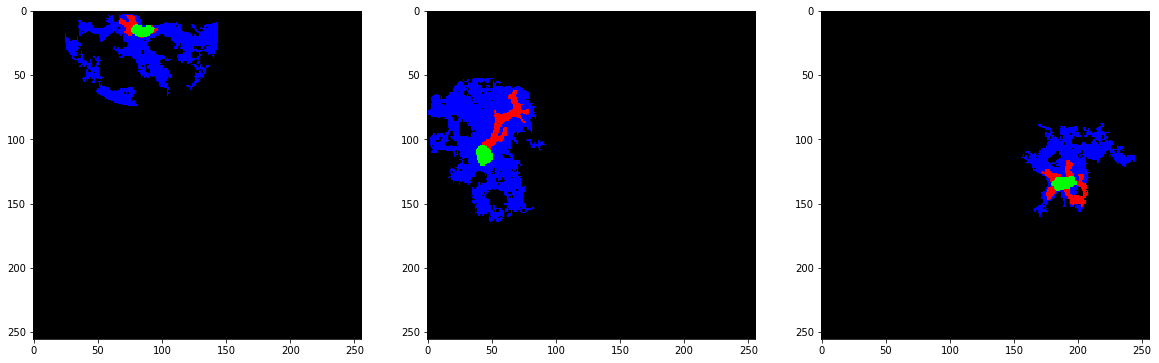

In [13]:
fig,[ax1,ax2,ax3] =plt.subplots(figsize=(20,20),ncols=3,nrows=1)
for j,a in zip(cell,[ax1,ax2,ax3]):
    a.imshow(mask_ROI[j,:,:,:])

# Dislpay

In [11]:
fov_name = []
for j in [2]:
    j = str(j)
    if len(j)==1:
        j='00'+j
    else:
        j='0'+j
    fov_name.append(j)
fov_name


['002']

In [12]:
hbox,button,display_plot = layout(fov_name,dict_im)
display(hbox)
button.on_click(display_plot)

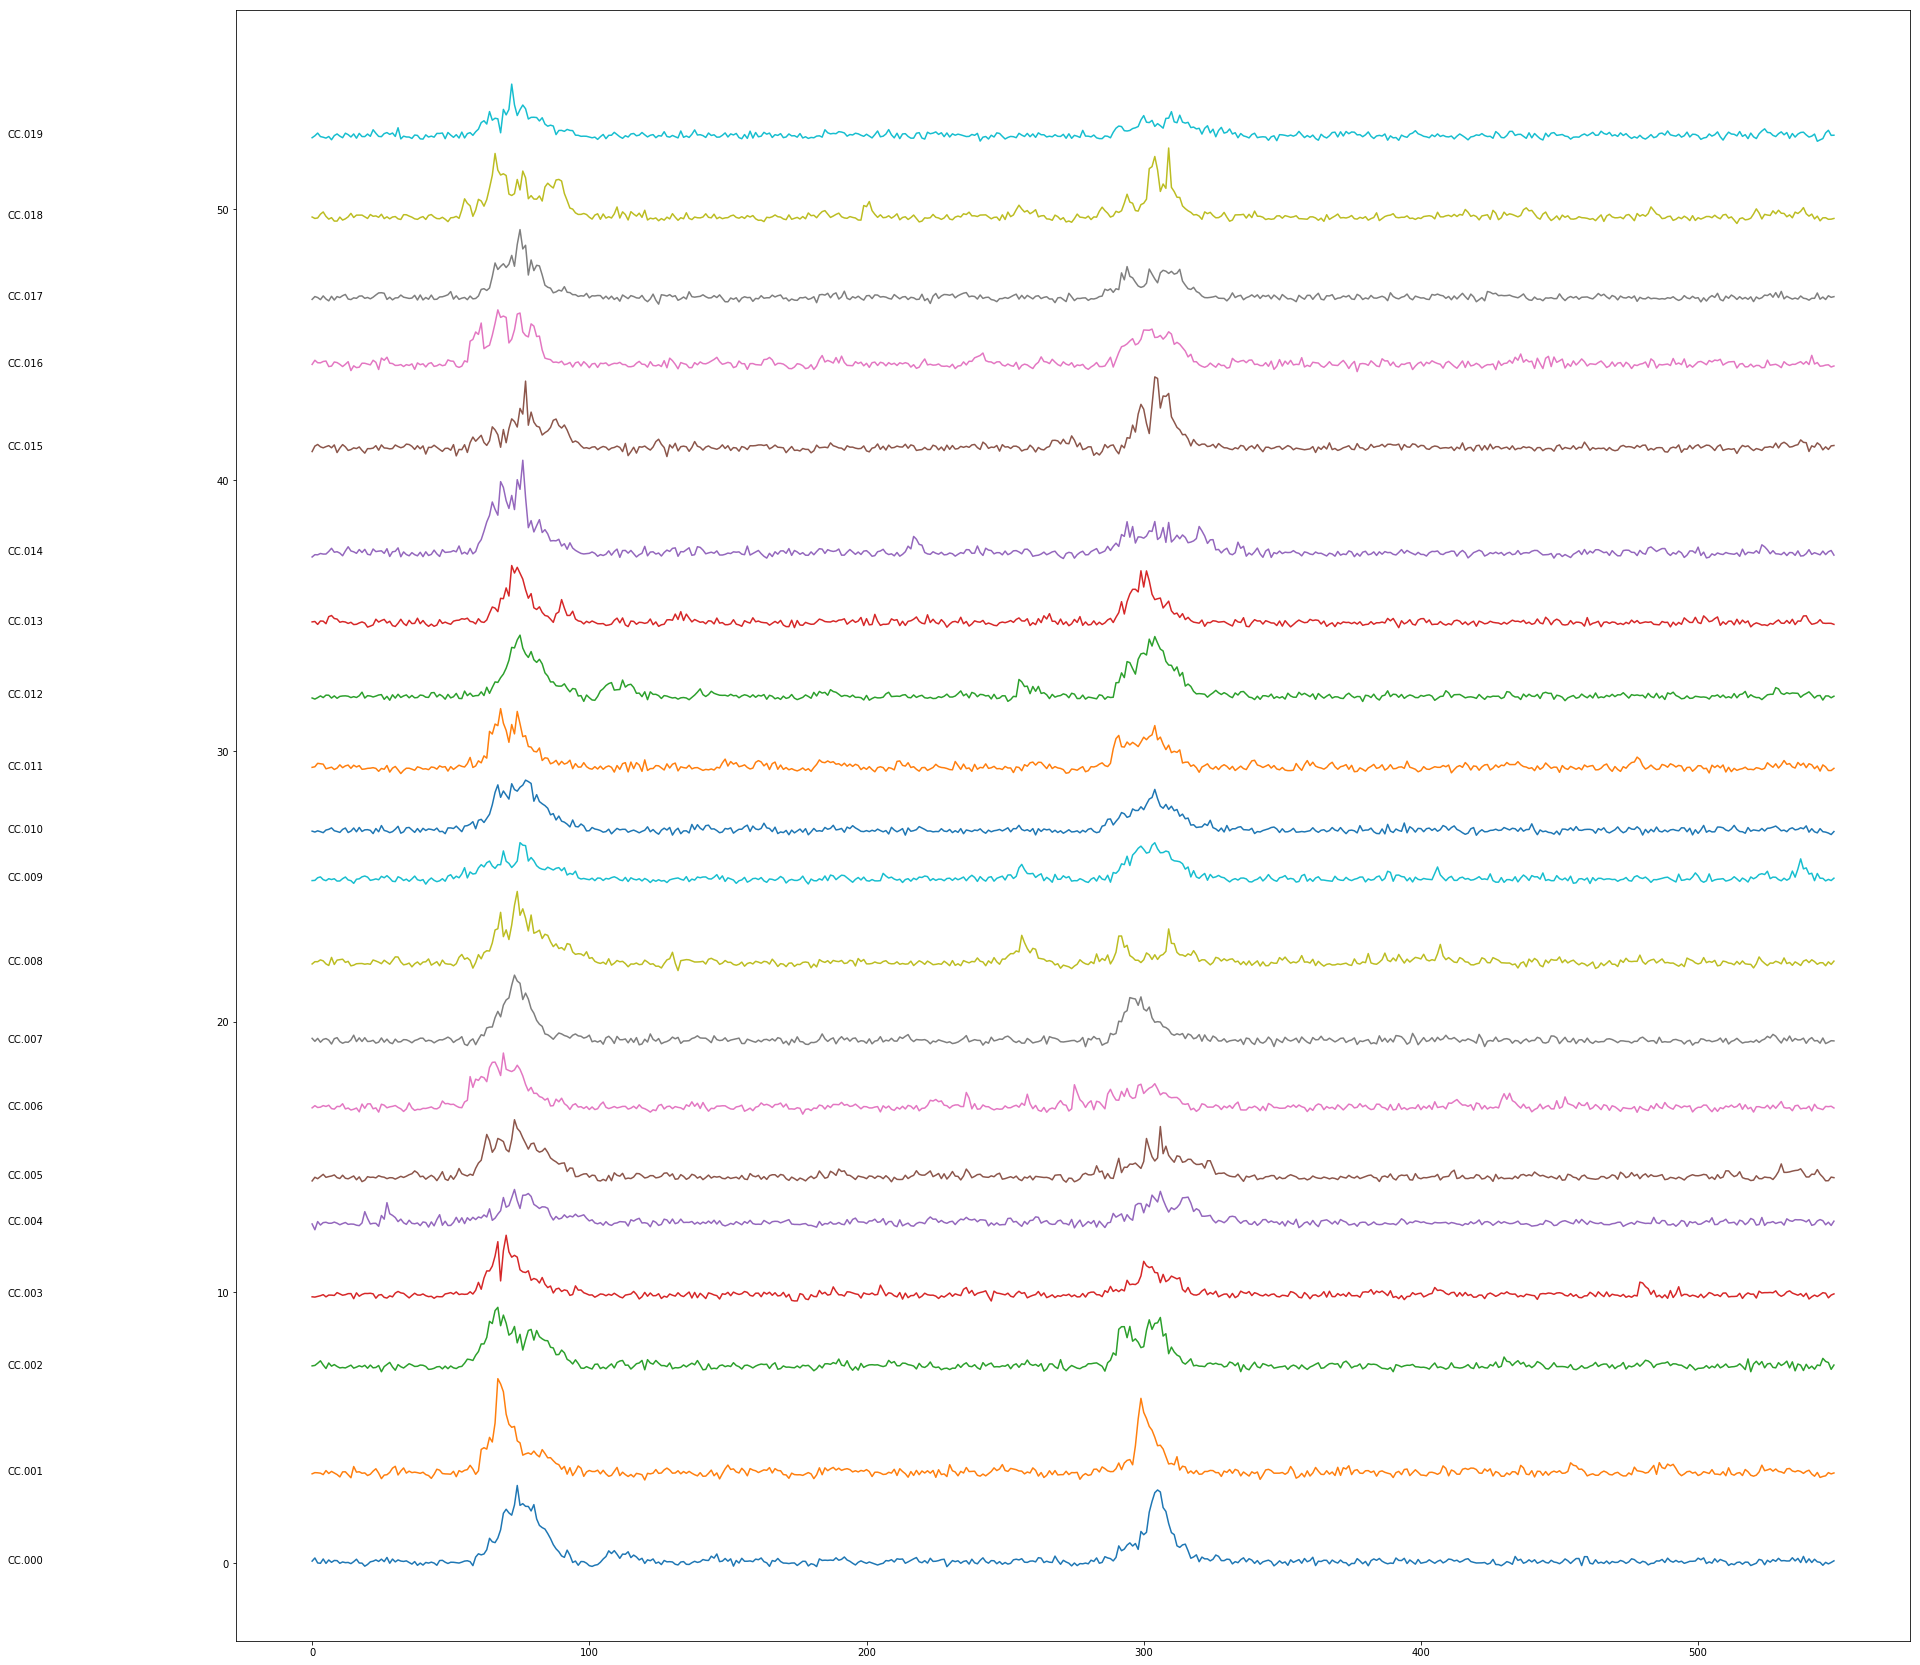

In [15]:
def plot_traces(dict_,cell_num,window,ax):
    MAX_traces=20
    
    traces = []
    name=[]
    cnt=0
    for key in dict_.keys():
        if 'CC_'+f'{str(cell_num):0>3}'+'_' in key and cnt<= MAX_traces:
            traces.append(dict_[key])
            name.append('CC.'+str(key[-3:]))
            cnt+=1
    traces = np.asarray(traces)
    #print(traces.shape)
    f0 = get_f0(traces,window)
    traces = (traces-f0)/(f0+0.0001)
    delta = 0
    for j in range(np.minimum(traces.shape[0],MAX_traces)):
        if np.max(traces[j,:])>100 or np.max(traces[j,:])==np.nan:
            traces[j,:]=0
            ax.plot(np.arange(traces.shape[1]),traces[j,:]+delta)
            ax.text(x = -traces.shape[1]/5, y= 0+delta, s =name[j] , rotation = 0,fontsize= 10)
            delta+= traces[j,:].max()+1
        else:
            ax.plot(np.arange(traces.shape[1]),traces[j,:]+delta)
            ax.text(x = -traces.shape[1]/5, y= 0+delta, s =name[j] , rotation = 0,fontsize= 10)
            delta+= traces[j,:].max()+0.4
            
def get_f0(traces,window):
    baseline = np.zeros_like(traces).astype(np.float32)
    for i in range(traces.shape[1]):
        if i<window:
            st=0
        else:
            st=i-window
        if i>traces.shape[1]-window:
            end = -1
        else:
            end=i+window

        baseline[:,i] = np.percentile(traces[:,st:end],20,axis=1)

    return baseline          

fig,ax = plt.subplots(figsize=(30,30),ncols=1,nrows=1)
plot_traces(dict_im['Signals_extr_'+query],1,20,ax)